In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None  # default='warn'

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp

ds_name = '02172021'
ds_folder = f'../data/{ds_name}'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/02172021/test.csv
../data/02172021/train.csv
../data/02172021/edges.csv
../data/02172021/cluster_dynamics.csv
../data/02172021/split_rs123/test.csv
../data/02172021/split_rs123/train.csv
../data/02172021/split_rs123/test_edge.csv
../data/02172021/split_rs123/train_edge.csv


In [2]:
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

In [3]:
#Import the files
node_df = pd.read_csv(f'{ds_folder}/cluster_dynamics.csv')
edge_df = pd.read_csv(f'{ds_folder}/edges.csv')

In [4]:
print('Shape of node data is', node_df.shape)
print ('Shape of edge data is', edge_df.shape)

Shape of node data is (586165, 19)
Shape of edge data is (585751, 5)


In [5]:
edge_df.tail()

,from,to,weight1,weight2,sim
585746,1343,76,10,0.009003,971
585747,1343,459,19,0.018519,971
585748,1342,1344,2,0.001731,971
585749,1344,373,24,0.019827,971
585750,1344,400,24,0.019809,971


### Count number of trees

In [6]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 414


### Analysis the edge weights

In [7]:
aly_edge_feat_cols = ['weight1', 'weight2']
aly_edge_df = edge_df[aly_edge_feat_cols]

In [8]:
aly_edge_df.describe()

,weight1,weight2
count,585751.000000,585751.000000
mean,10.772572,0.009694
std,8.947767,0.008092
min,0.000000,0.000000
25%,4.000000,0.003384
50%,8.000000,0.007592
75%,16.000000,0.014021
max,83.000000,0.079761


array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>]], dtype=object)

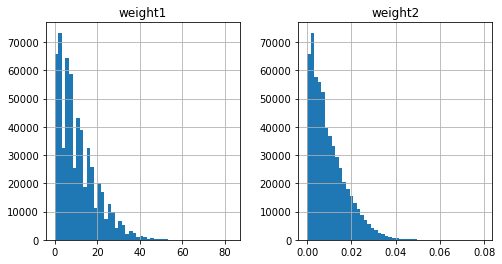

In [9]:
aly_edge_df.hist(bins=50,figsize=(8,4))

In [10]:
# Compute pairwise correlation of columns (pearson R: standard correlation coefficient)
aly_edge_df.corr()

,weight1,weight2
weight1,1.000000,0.994977
weight2,0.994977,1.000000


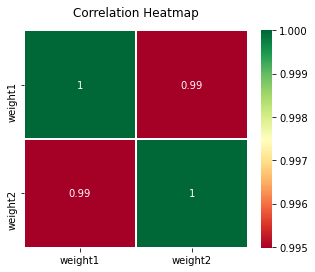

In [11]:
# Pearson Correlation Matrix

# Increase the size of the heatmap.
plt.figure(figsize=(5, 4))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_edge_df.corr(), annot=True, linewidths=.5, cmap="RdYlGn")
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', pad=14);

### Get the node and edge distribution of the trees

In [12]:
from collections import defaultdict

tree_dist_dict = defaultdict(list)

for tree_id in tree_ids:
    tree_dist_dict['sim'].append(tree_id)
    onetree_node_df = node_df[node_df['sim'] == tree_id] 
    num_nodes = onetree_node_df.shape[0]
    tree_dist_dict['num_nodes'].append(num_nodes)
    
    num_background_nodes = onetree_node_df[onetree_node_df['cluster_id']=='Background'].shape[0]
    tree_dist_dict['num_background_nodes'].append(num_background_nodes)
    tree_dist_dict[f'rat_background_nodes'].append(num_background_nodes / num_nodes)
    
    for label in ['static', 'growth', 'decay']:
        num_label_nodes = onetree_node_df[onetree_node_df['dynamic']==label].shape[0]
        tree_dist_dict[f'num_{label}_nodes'].append(num_label_nodes)
        tree_dist_dict[f'rat_{label}_nodes'].append(num_label_nodes / num_nodes)
        
    onetree_edge_df = edge_df[edge_df['sim'] == tree_id]
    # print(onetree_edge_df.shape)
    tree_dist_dict['num_edges'].append(onetree_edge_df.shape[0])
    
tree_dist_df = pd.DataFrame.from_dict(tree_dist_dict)

array([[<AxesSubplot:title={'center':'sim'}>,
        <AxesSubplot:title={'center':'num_nodes'}>,
        <AxesSubplot:title={'center':'num_background_nodes'}>],
       [<AxesSubplot:title={'center':'rat_background_nodes'}>,
        <AxesSubplot:title={'center':'num_static_nodes'}>,
        <AxesSubplot:title={'center':'rat_static_nodes'}>],
       [<AxesSubplot:title={'center':'num_growth_nodes'}>,
        <AxesSubplot:title={'center':'rat_growth_nodes'}>,
        <AxesSubplot:title={'center':'num_decay_nodes'}>],
       [<AxesSubplot:title={'center':'rat_decay_nodes'}>,
        <AxesSubplot:title={'center':'num_edges'}>, <AxesSubplot:>]],
      dtype=object)

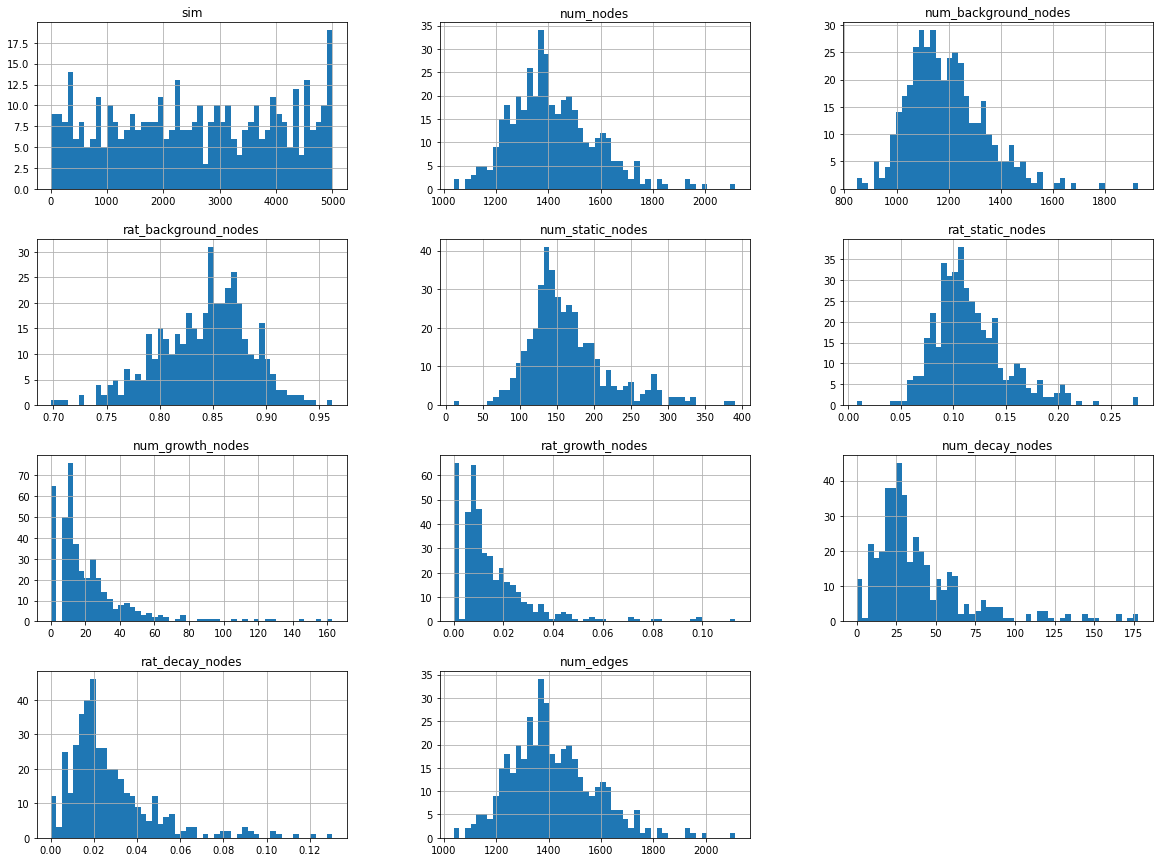

In [13]:
tree_dist_df.hist(bins=50,figsize=(20,15))

### Split the train/test sets

In [14]:
random_seed = 123
np.random.seed(random_seed)
split_folder = f'../data/{ds_name}/split_rs{random_seed}'
os.makedirs(split_folder, exist_ok=True)

from sklearn.model_selection import  train_test_split
#split the data for training and testing
train_ids, test_ids = train_test_split(tree_ids, test_size=0.2)
print(f"Train: {len(train_ids)}, Test: {len(test_ids)}")
print(test_ids[:10])

Train: 331, Test: 83
[ 309  863 3115 2155 3363 1091 2591 1596 1106 1113]


In [15]:
train_edge_df = edge_df[edge_df['sim'].isin(train_ids)]
test_edge_df = edge_df[edge_df['sim'].isin(test_ids)]

print(f'Train edges: {train_edge_df.shape[0]}')
print(f'Test edges: {test_edge_df.shape[0]}')

Train edges: 467666
Test edges: 118085


### Normalize the edge weights

array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>]], dtype=object)

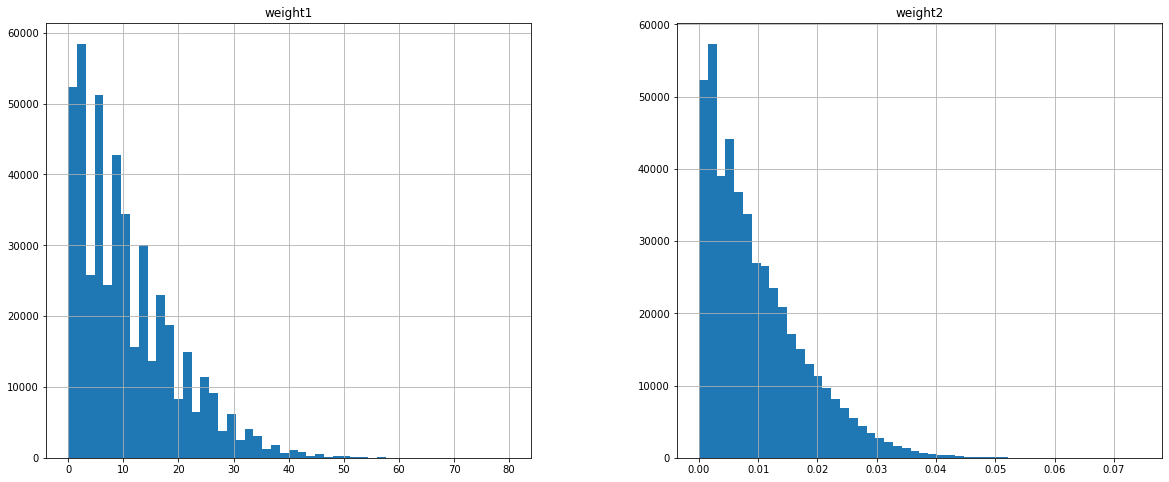

In [16]:
train_edge_df[aly_edge_feat_cols].hist(bins=50,figsize=(20,8))

In [17]:
train_edge_df['weight1'].describe()

count    467666.000000
mean         10.802457
std           8.972370
min           0.000000
25%           4.000000
50%           8.000000
75%          16.000000
max          80.000000
Name: weight1, dtype: float64

In [18]:
train_edge_df.loc[:, 'weight1_arsinh'] = np.arcsinh(train_edge_df['weight1'])

In [19]:
train_edge_df['weight2'].describe()

count    467666.000000
mean          0.009721
std           0.008115
min           0.000000
25%           0.003388
50%           0.007609
75%           0.014069
max           0.074415
Name: weight2, dtype: float64

In [20]:
train_edge_df.loc[:, 'weight2_arsinh'] = np.arcsinh(train_edge_df['weight2'])

array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>],
       [<AxesSubplot:title={'center':'weight1_arsinh'}>,
        <AxesSubplot:title={'center':'weight2_arsinh'}>]], dtype=object)

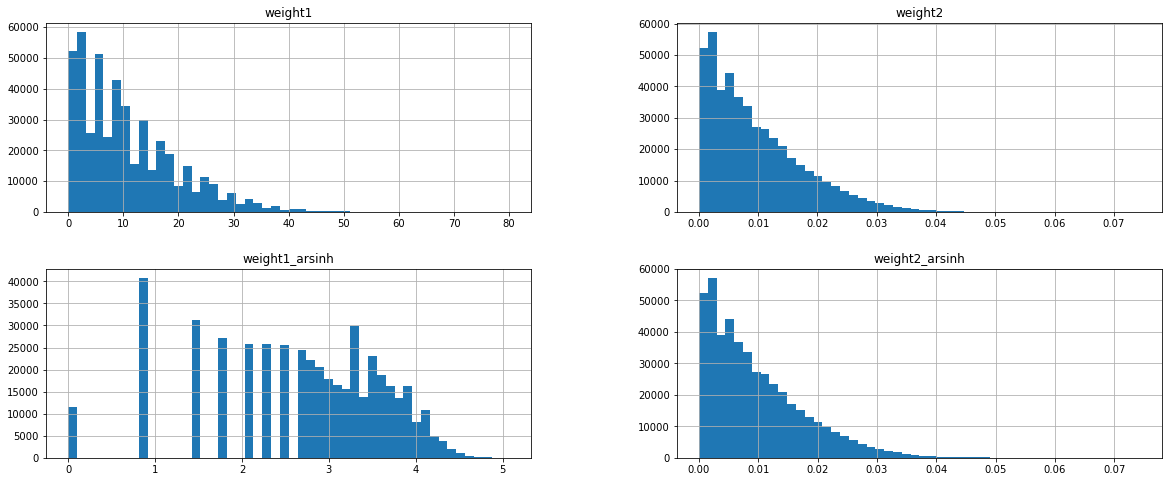

In [21]:
aly_edge_feat_cols += ['weight1_arsinh', 'weight2_arsinh']

train_edge_df[aly_edge_feat_cols].hist(bins=50,figsize=(20,8))

In [22]:
from sklearn import preprocessing

# Standardization edge features
std_scaler = preprocessing.StandardScaler().fit(train_edge_df[aly_edge_feat_cols])
norm_num_feat_cols = [f'{col_name}-norm' for col_name in aly_edge_feat_cols]

norm_train_vals = std_scaler.transform(train_edge_df[aly_edge_feat_cols])
norm_train_edge_df = pd.DataFrame(norm_train_vals, columns=norm_num_feat_cols, index=train_edge_df.index)
train_edge_df = pd.concat([train_edge_df, norm_train_edge_df], axis=1)

In [23]:
train_edge_df

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
0,739,740,8,0.007590,1001,2.776472,0.007590,-0.312343,-0.262548,0.108639,-0.262523
1,740,741,7,0.006588,1001,2.644121,0.006588,-0.423797,-0.386090,-0.021365,-0.386081
2,741,742,9,0.007705,1001,2.893444,0.007705,-0.200890,-0.248377,0.223535,-0.248351
3,742,743,4,0.003558,1001,2.094713,0.003558,-0.758157,-0.759455,-0.561027,-0.759495
4,743,744,4,0.003769,1001,2.094713,0.003769,-0.758157,-0.733462,-0.561027,-0.733498
...,...,...,...,...,...,...,...,...,...,...,...
585746,1343,76,10,0.009003,971,2.998223,0.009002,-0.089437,-0.088535,0.326455,-0.088491
585747,1343,459,19,0.018519,971,3.638278,0.018518,0.913644,1.084091,0.955156,1.084190
585748,1342,1344,2,0.001731,971,1.443635,0.001731,-0.981064,-0.984617,-1.200554,-0.984688
585749,1344,373,24,0.019827,971,3.871635,0.019826,1.470911,1.245360,1.184373,1.245453


In [24]:
print(std_scaler.mean_, std_scaler.scale_)

[1.08024573e+01 9.72105519e-03 2.66587172e+00 9.72047407e-03] [8.97236025e+00 8.11515525e-03 1.01806033e+00 8.11397600e-03]


In [25]:
# Update the feat_dict.json
import json

js_f = osp.join('./feat_dict.json')

with open(js_f, 'r') as infile:
    feat_dict = json.load(infile)

feat_dict['raw_edge_feats'] = aly_edge_feat_cols
feat_dict['norm_edge_feats'] = [f'{org_feat_col}-norm' for org_feat_col in aly_edge_feat_cols]

node_feat_cols = feat_dict['norm_onehot_feats']
raw_edge_feat_cols = feat_dict['raw_edge_feats']
norm_edge_feat_cols = feat_dict['norm_edge_feats']

print(f'Inputs: {len(node_feat_cols)}, {node_feat_cols}')
label_feat_col = 'dynamic_cat'

with open(js_f, 'w') as outfile:
    json.dump(feat_dict, outfile, sort_keys=True, indent=4)

Inputs: 21, ['v_sampling_fraction-norm', 'v_cluster_size-norm', 'v_timespan-norm', 'oster-norm', 'birth_rate-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'R0_cat_0', 'R0_cat_1', 'R0_cat_2', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']


In [26]:
test_edge_df.loc[:, 'weight1_arsinh'] = np.arcsinh(test_edge_df['weight1'])
test_edge_df.loc[:, 'weight2_arsinh'] = np.arcsinh(test_edge_df['weight2'])
test_edge_df

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh
7392,573,574,1,0.000971,104,0.881374,0.000971
7393,574,575,12,0.011404,104,3.179785,0.011404
7394,575,576,3,0.002783,104,1.818446,0.002783
7395,576,577,35,0.032654,104,4.248699,0.032648
7396,577,84,13,0.011780,104,3.259573,0.011780
...,...,...,...,...,...,...,...
580170,1273,1275,17,0.014339,893,3.527224,0.014339
580171,1275,34,2,0.001610,893,1.443635,0.001610
580172,1275,1276,12,0.011020,893,3.179785,0.011019
580173,1276,178,2,0.001828,893,1.443635,0.001828


In [28]:
norm_test_vals = std_scaler.transform(test_edge_df[raw_edge_feat_cols])
norm_test_edge_df = pd.DataFrame(norm_test_vals, columns=norm_edge_feat_cols, index=test_edge_df.index)
test_edge_df = pd.concat([test_edge_df, norm_test_edge_df], axis=1)

In [29]:
test_edge_df.head()

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
7392,573,574,1,0.000971,104,0.881374,0.000971,-1.092517,-1.078246,-1.752841,-1.078331
7393,574,575,12,0.011404,104,3.179785,0.011404,0.133470,0.207420,0.504797,0.207491
7394,575,576,3,0.002783,104,1.818446,0.002783,-0.869610,-0.854995,-0.832392,-0.855048
7395,576,577,35,0.032654,104,4.248699,0.032648,2.696898,2.825966,1.554748,2.825734
7396,577,84,13,0.011780,104,3.259573,0.011780,0.244924,0.253723,0.583169,0.253798


array([[<AxesSubplot:title={'center':'weight1-norm'}>,
        <AxesSubplot:title={'center':'weight2-norm'}>],
       [<AxesSubplot:title={'center':'weight1_arsinh-norm'}>,
        <AxesSubplot:title={'center':'weight2_arsinh-norm'}>]],
      dtype=object)

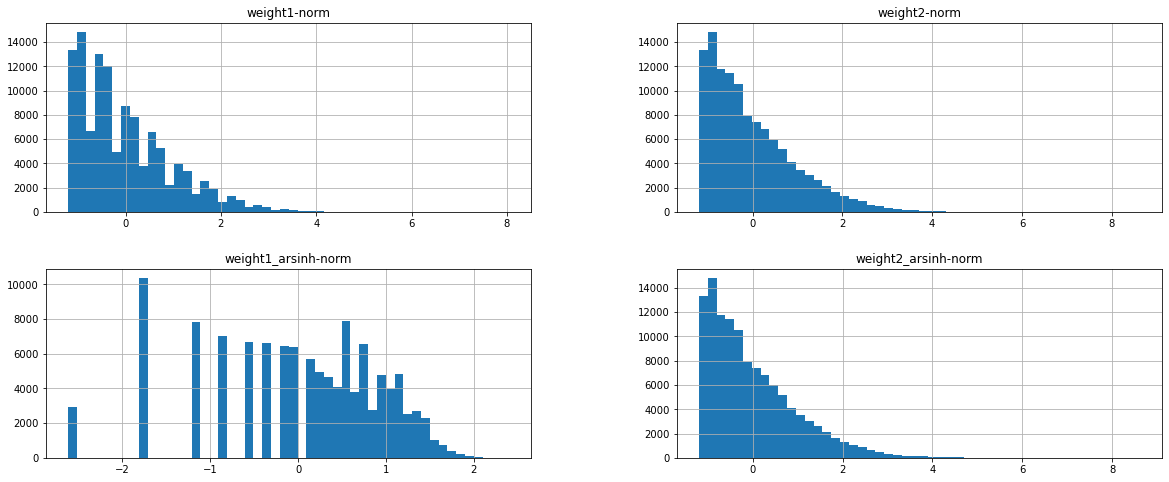

In [30]:
test_edge_df[norm_edge_feat_cols].hist(bins=50,figsize=(20,8))

In [31]:
# Save the train/test to the disk

train_edge_df.to_csv(f'{split_folder}/train_edge.csv', index=False)
test_edge_df.to_csv(f'{split_folder}/test_edge.csv', index=False)

### Build a tree with DGL

In [32]:
import networkx as nx
import matplotlib.pyplot as plt

In [33]:
# Load a tree from the train data
train_node_df = pd.read_csv(f'{split_folder}/train.csv')
vis_tree_id = train_ids[0]
print(vis_tree_id)

1920


/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,3,4,16,19,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [34]:
onetree_node_df = train_node_df[train_node_df['sim'] == vis_tree_id] 
onetree_edge_df = train_edge_df[edge_df['sim'] == vis_tree_id]

/home/yanjun/anaconda3/envs/pyt-1.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [35]:
onetree_node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm
14946,c1,1920,A,static,stable,0.973455,57.0,39.0,1.40439,39.008133,...,1.272573,-0.127953,1.23276,1.233026,-0.054826,0.365631,-0.028655,1.192954,0.025027,0.268155
14947,c1,1920,A,static,stable,0.973455,57.0,39.0,1.40439,39.008133,...,1.272573,-0.127953,1.23276,1.233026,-0.054826,0.365631,-0.028655,1.192954,0.025027,0.268155
14948,c1,1920,A,static,stable,0.973455,57.0,39.0,1.40439,39.008133,...,1.272573,-0.127953,1.23276,1.233026,-0.054826,0.365631,-0.028655,1.192954,0.025027,0.268155
14949,c1,1920,A,static,stable,0.973455,57.0,39.0,1.40439,39.008133,...,1.272573,-0.127953,1.23276,1.233026,-0.054826,0.365631,-0.028655,1.192954,0.025027,0.268155
14950,c1,1920,A,static,stable,0.973455,57.0,39.0,1.40439,39.008133,...,1.272573,-0.127953,1.23276,1.233026,-0.054826,0.365631,-0.028655,1.192954,0.025027,0.268155


In [36]:
onetree_edge_df

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
117006,711,712,17,0.015831,1920,3.527224,0.015830,0.690737,0.752870,0.846072,0.752969
117007,712,713,4,0.003808,1920,2.094713,0.003808,-0.758157,-0.728629,-0.561027,-0.728664
117008,713,714,1,0.000895,1920,0.881374,0.000895,-1.092517,-1.087559,-1.752841,-1.087645
117009,714,715,11,0.010987,1920,3.093102,0.010987,0.022017,0.155992,0.419651,0.156059
117010,715,280,55,0.047606,1920,4.700563,0.047588,4.925966,4.668392,1.998596,4.666928
...,...,...,...,...,...,...,...,...,...,...,...
118373,1372,174,10,0.008721,1920,2.998223,0.008721,-0.089437,-0.123279,0.326455,-0.123239
118374,1372,606,10,0.009335,1920,2.998223,0.009335,-0.089437,-0.047533,0.326455,-0.047485
118375,1371,1373,7,0.006054,1920,2.644121,0.006054,-0.423797,-0.451925,-0.021365,-0.451924
118376,1373,242,18,0.017520,1920,3.584290,0.017519,0.802191,0.960990,0.902125,0.961091


In [37]:
import dgl
import networkx as nx
import torch
import pygraphviz as pgv

Using backend: pytorch


In [38]:
src_ids = torch.tensor(onetree_edge_df['from'].values)
dst_ids = torch.tensor(onetree_edge_df['to'].values)

# Note: the start idx of the node is 0 not 1. But simulation node starts with 1
# We need substract 1 to the node idx for edges and nodes files.
src_ids -= 1
dst_ids -= 1

In [39]:
g = dgl.graph((src_ids, dst_ids))
nx_g = dgl.to_networkx(g)

print(f'Nodes: {g.number_of_nodes()}')
print(f'Edges: {g.number_of_edges()}')

Nodes: 1373
Edges: 1372


In [40]:
g.nodes()

tensor([   0,    1,    2,  ..., 1370, 1371, 1372])

### Assign features to nodes

In [41]:
sorted_onetree_node_df = onetree_node_df.sort_values(by='node')
print(sorted_onetree_node_df['node'].values)
n_nodes = sorted_onetree_node_df.shape[0]
sorted_onetree_node_df.tail()

[   1    2    3 ... 1371 1372 1373]


,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,...,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm
147439,Background,1920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147409,Background,1920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147429,Background,1920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147454,Background,1920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147427,Background,1920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

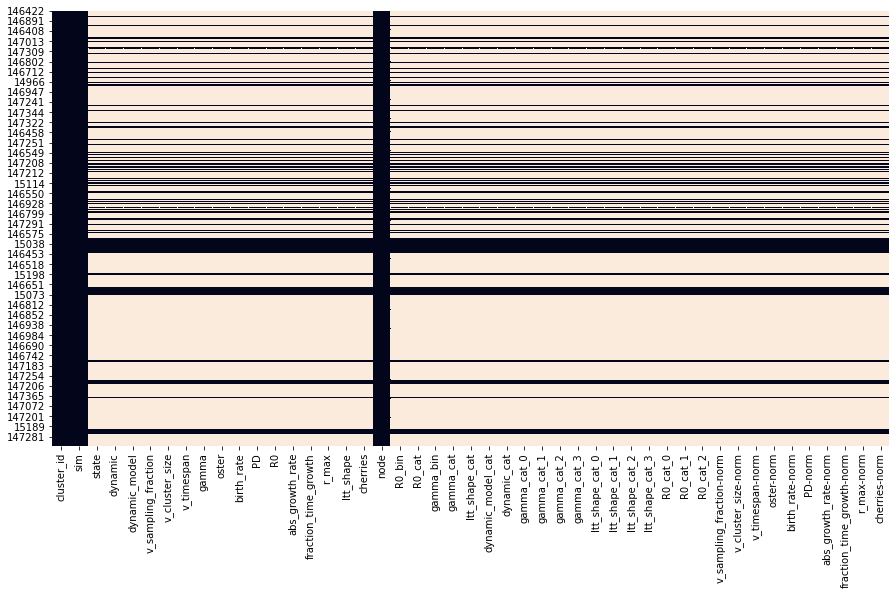

In [42]:
# Now using heatmaps
plt.figure(figsize=(15,8))
sns.heatmap(sorted_onetree_node_df.isnull(), cbar=False)

<AxesSubplot:>

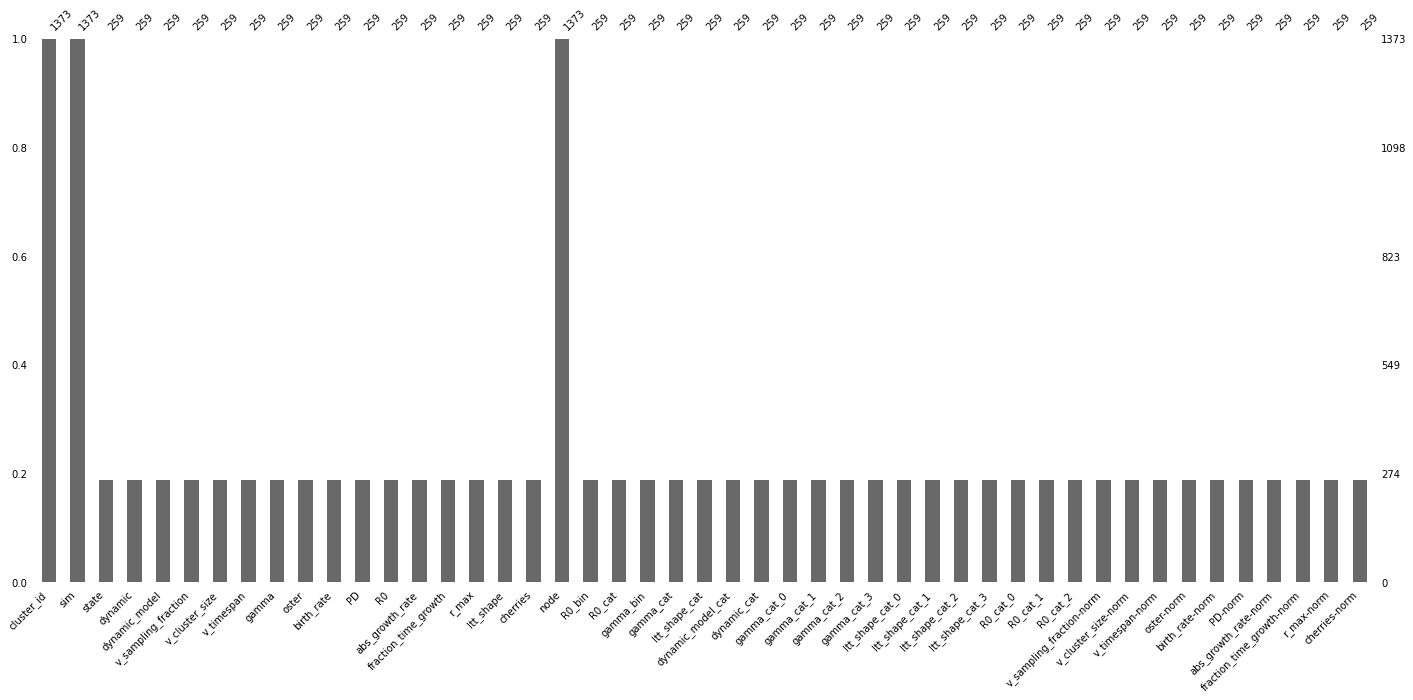

In [43]:
# Next is to use the missingno library to analyze the missing values
import missingno as msno 

msno.bar(sorted_onetree_node_df,labels=True,fontsize=10) 

In [44]:
g.ndata['feat'] = torch.tensor(sorted_onetree_node_df[node_feat_cols].values)
g.ndata['label'] = torch.tensor(sorted_onetree_node_df[label_feat_col].values)

for i in range(n_nodes):
    if not torch.all(torch.isnan(g.ndata['feat'][i])):
        print(f"NodeID: {i+1}, {g.ndata['feat'][i]}, {g.ndata['label'][i]}")
        break

NodeID: 10, tensor([ 1.2726, -0.1280,  1.2328,  1.2330, -0.0548,  0.3656, -0.0287,  1.1930,
         0.0250,  0.2682,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  0.0000], dtype=torch.float64), 2.0


### Assign features to edges

In [45]:
g.edges()

(tensor([ 710,  711,  712,  ..., 1370, 1372, 1372]),
 tensor([ 711,  712,  713,  ..., 1372,  241,  534]))

In [46]:
# The edge features are assigned to the edata according to the edge order, not considerring the src and dst
g.edata['feat'] = torch.tensor(onetree_edge_df[norm_edge_feat_cols].values)
g.edata['feat'][0]

tensor([0.6907, 0.7529, 0.8461, 0.7530], dtype=torch.float64)

defaultdict(<function <lambda> at 0x7fd420e257b8>, {'bg': 1114, 2.0: 179, 0.0: 30, 1.0: 50})


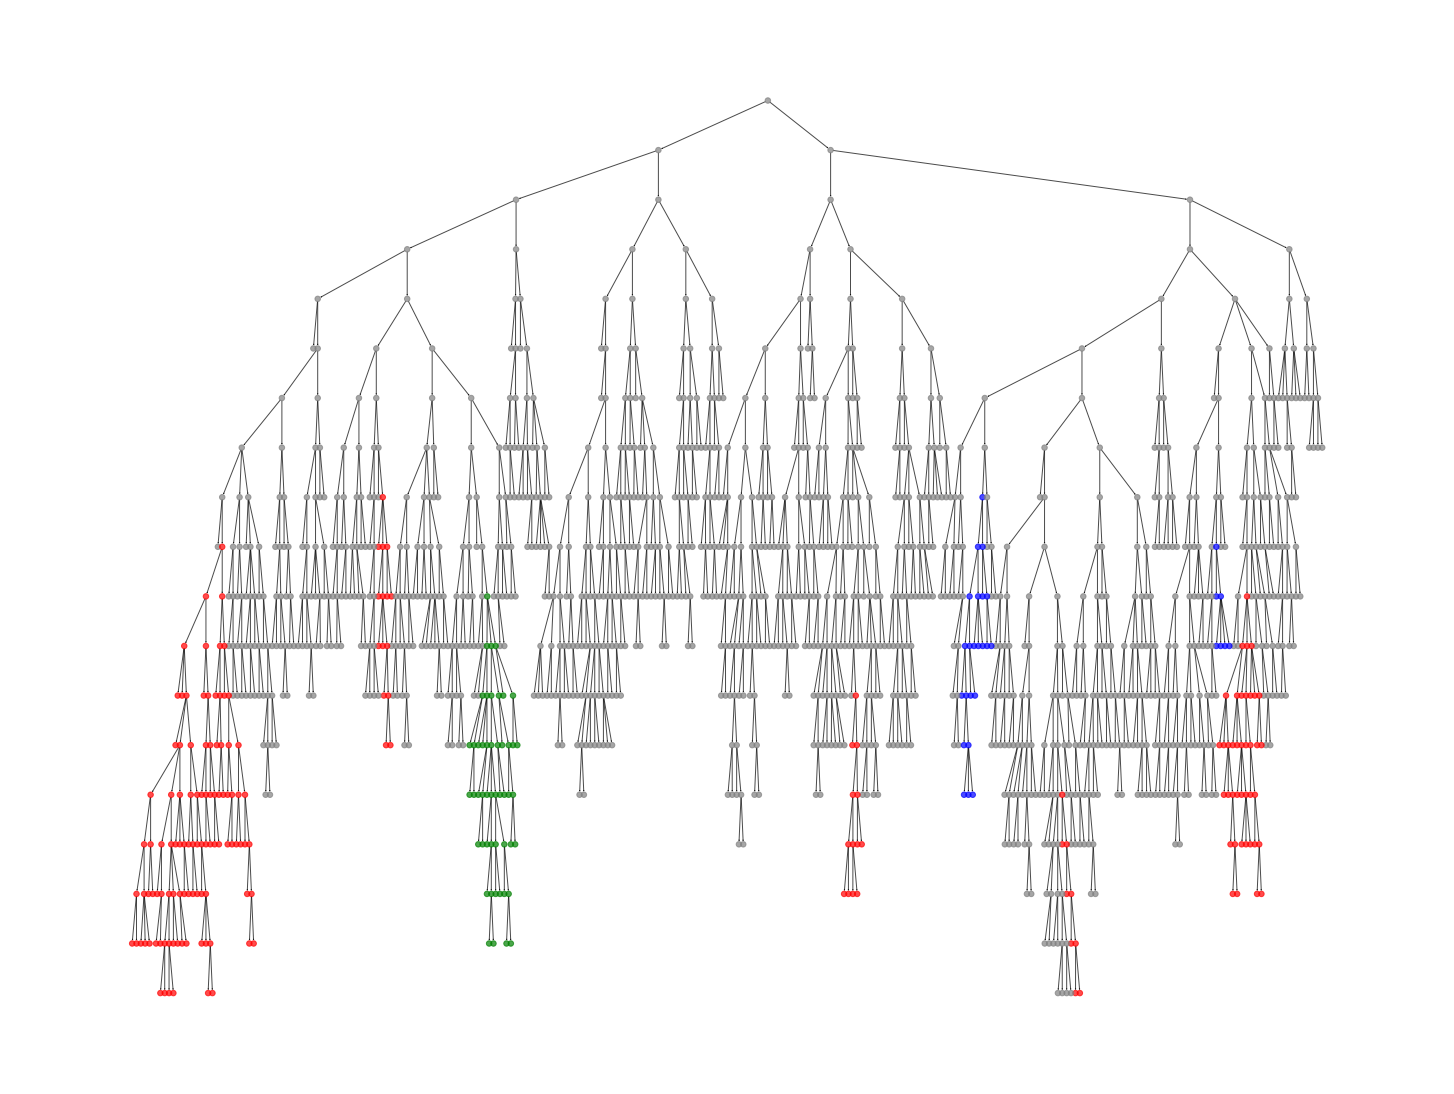

In [47]:
plt.figure(figsize=(20, 15))
color_map = []
node_labels = g.ndata['label'].numpy()
label_counter = defaultdict(lambda: 0)

for node_id in nx_g:
    node_label = node_labels[node_id]
    if np.isnan(node_label):
        label_counter['bg'] += 1
        color_map.append('gray')
    else:
        if node_label == 0:  # decay
            color_map.append('blue')
        elif node_label == 1:   # growth
            color_map.append('green')
        elif node_label == 2:   # static
            color_map.append('red')
        label_counter[node_label] += 1
            
print(label_counter)
pos = nx.nx_agraph.graphviz_layout(nx_g, prog='dot')
nx.draw(nx_g, pos, with_labels=False, node_size=30, node_color=color_map, alpha=.7, arrowsize=1)